# pyEDITH Tutorial: Spectroscopy Mode

This tutorial will guide you through using pyEDITH in spectroscopy mode. We'll explore how to set up parameters, run the Exposure Time Calculator (ETC), and analyze the results for spectroscopic observations.

.. note:: 
If you're new to pyEDITH or need a refresher on basic concepts, please refer to the [Imaging Mode Tutorial](imaging_tutorial.ipynb) first. The imaging tutorial covers fundamental concepts that are also applicable to spectroscopy mode.


## 1. Usage
In this section, we will use the classes previously defined to run spectroscopic noise simulations.

### 1.1 Setup and Imports

First, let's import the necessary modules and set up our environment:


In [9]:
import pyEDITH as pE
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Set the necessary environment variables
# Replace with your paths or add to your .bashrc/.zshrc:
# export SCI_ENG_DIR="/path/to/Sci-Eng-Interface/hwo_sci_eng"
# export YIP_CORO_DIR="/path/to/yips"



We now set up a parameters dictionary. This is where all the input parameters are stored for EDITH.

In [10]:
parameters = {}
parameters["observing_mode"] = "IFS" # tells ETC to use spectroscopy (IFS) mode


### 1.1.1 Observation
We now set up the **Observation** class. Eventually, this is where the exposure time or SNR will be placed after calculation. To set up the observation object, we need to specify a few overarching parameters:


In [11]:
# define a wavelength grid in microns
parameters["wavelength"] = np.linspace(0.2, 1.8, 1000)     

# number of wavelengths
parameters["nlambd"] = len(parameters["wavelength"])    

# the SNR you want for each spectral bin 
parameters["snr"] = 7*np.ones_like(parameters["wavelength"]) 

# factor to multiply the background by (used for differential imaging)  
parameters["CRb_multiplier"] = 2.          
       
# truncate the off-axis PSFs at this level               
parameters["psf_trunc_ratio"] = 0.3                             


To get a more realistic wavelength grid, we can tell the ETC to regrid our user-supplied wavelength grid and spectra onto a new wavelength grid. This is optional. If you don't want to re-grid, then set `parameters["regrid_wavelength"] = False`


In [12]:
# set the flag to do this. We also need to specify a few other parameters.
parameters["regrid_wavelength"] = True  

# we're going to define three spectral channels. These are the spectral resolutions for each channel 
# i.e. all spectral bins in a given channel will have a fixed resolution.
parameters["spectral_resolution"] = np.array([7, 140, 40])     

# the lower wavelength bounds for each spectral channel
parameters['lam_low'] = [0.3, 0.4, 1.]                          

# the upper wavelength bounds for each spectral channel
parameters['lam_high'] = [0.4, 1., 1.7]                         


There are more parameters we can define (see below), but these are the basics for now. With these parameters, we can populate the Observation class.



In [13]:
observation = pE.Observation() 

# load the specified configuration in the parameters dict 
observation.load_configuration(parameters) 
observation.set_output_arrays()
observation.validate_configuration()



Calculating a new wavelength grid and re-gridding spectra...


### 1.1.2 Astrophysical Scene
Up next, the **Astrophysical Scene** object. We will use a blackbody spectrum for a Solar-like star and a template for an Earth-like reflectance spectrum for the purposes of this tutorial.

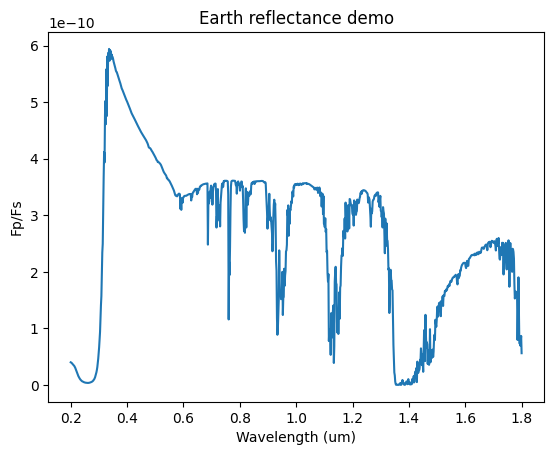

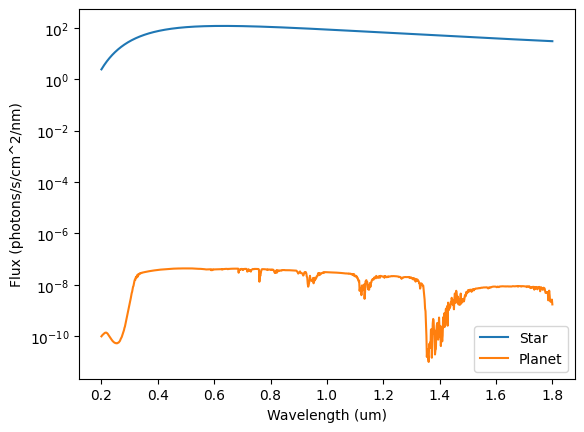

In [14]:
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot import units as synphot_u
import astropy.units as u 
import astropy.constants as c 

def compute_blackbody_photon_flux(temp, wavelengths):
    """Generate photon flux density (photon/s/cm^2/um) for a blackbody at 1 cm^2."""
    bb = SourceSpectrum(BlackBodyNorm1D, temperature=temp)
    

    flux_photlam = bb(wavelengths)#.value * 1/(u.s * u.cm**2 * u.AA) # photons/s/cm2/A
    return flux_photlam

def compute_star_flux_observed(stellar_flux_surface, R_star, dist):
    """Scale stellar surface flux to observer distance."""
    scale = (R_star / dist)**2
    return stellar_flux_surface * scale.decompose()


# temp and distance to star
Tstar = 5800 * u.K
dist = 10 * u.pc

# calculate the observed Fstar
Fstar = compute_blackbody_photon_flux(Tstar, parameters["wavelength"]*u.um)
Fstar = Fstar.to(u.photon / (u.s * u.cm**2 * u.nm)) # convert to pyEdith units
Fstar_obs_10pc = Fstar * (1000*u.pc/dist)**2 # this gives the flux at 1 kpc. Scale to the distance of the star

# calculate the observed Fp/Fs
earth_wl, earth_refl = np.loadtxt("../../inputs/earth_refl_demo.txt", delimiter=",").T
from scipy.interpolate import interp1d
earth_interp_func = interp1d(earth_wl, earth_refl)
FpFs = earth_interp_func(parameters["wavelength"])
Fplan_obs = Fstar_obs_10pc * FpFs

plt.figure()
plt.plot(parameters["wavelength"]*u.um, FpFs)
plt.xlabel("Wavelength (um)")
plt.ylabel("Fp/Fs")
plt.title("Earth reflectance demo")

plt.figure()
plt.plot(parameters["wavelength"]*u.um, Fstar_obs_10pc, label="Star")
plt.plot(parameters["wavelength"]*u.um, Fplan_obs, label="Planet")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (photons/s/cm^2/nm)")
plt.yscale("log")
plt.legend()



We need several more parameters to define the astrophysical scene. These include parameters related to the star, planet, zodi/exozodi...

As an example, lets take the star HD 102365. It is a sun-like star (spectral type G2V) ~10 pc away. 
It is also a Tier A target star from the NASA ExEP HWO target star list. 


In [15]:
# STAR
# distance to the system in pc
parameters["distance"] = 10. 

# radius of the star in solar radii
parameters["stellar_radius"] = 1. 

# Fstar modeled as a blackbody (see above)
parameters["Fstar_10pc"] = Fstar_obs_10pc.value 

# PLANET
# planetary separation in arcsec
parameters["separation"] = 0.1 

#Fp/Fs from Earth template (see above)
parameters["Fp/Fs"] = FpFs 

# SCENE
# number of zodis for exozodi estimate
parameters["nzodis"] = 1. 

# post-processing factor for stellar speckle subtraction
parameters["noisefloor_PPF"] = 30 

# approximate ra and dec of HD 102365. WARNING: do not use these numbers for science.
parameters["ra"] = 176.6292  
parameters["dec"] = -40.5003 

# perfect exozodi subtraction 
parameters["ez_PPF"] = np.inf 



With these parameters, we can populate the AstrophysicalScene class.

In [16]:
scene = pE.AstrophysicalScene()
scene.load_configuration(parameters)
scene.calculate_zodi_exozodi(parameters)
scene.validate_configuration()

 

.. important::
If you chose to let the ETC re-grid your input spectra (using user supplied settings shown above, then you have to run this extra step). This will regrid the spectra to the specified resolution of the various channels.


In [17]:
if parameters["regrid_wavelength"] is True:
    scene.regrid_spectra(parameters, observation)


Re-gridding spectra onto ETC wavelength grid...


Text(0.5, 1.0, 'Absolute Flux of the Star')

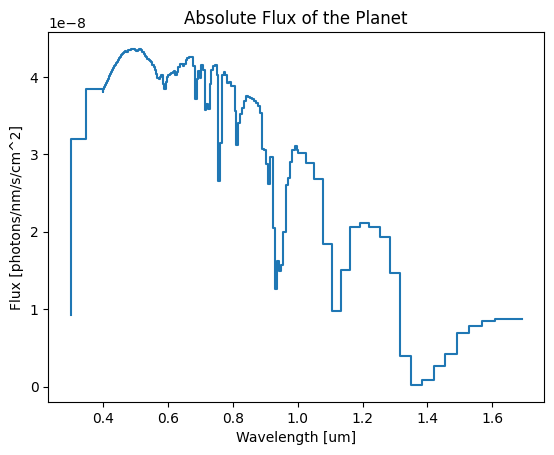

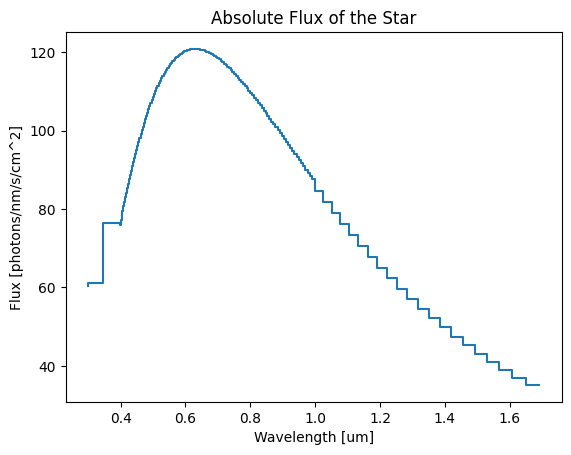

In [18]:
plt.figure()
plt.step(observation.wavelength, (getattr(scene, "Fs_over_F0")*getattr(scene, "F0")*getattr(scene, "Fp_over_Fs")))
plt.xlabel("Wavelength [um]")
plt.ylabel("Flux [photons/nm/s/cm^2]")
plt.title("Absolute Flux of the Planet")

plt.figure()
plt.step(observation.wavelength, (getattr(scene, "Fs_over_F0")*getattr(scene, "F0"))) # F0 is the zero-point and Fs_over_F0 is the ratio of the absolute flux to the zero point flux
plt.xlabel("Wavelength [um]")
plt.ylabel("Flux [photons/nm/s/cm^2]")
plt.title("Absolute Flux of the Star")

### 1.1.4 Observatory

Set up the observatory: telescope, coronagraph, detector.

Create and configure Observatory using ObservatoryBuilder.
This compiles the telescope, coronagraph, and detector and places them all in a single object. 
These parameters mostly come from the EAC YAML files, but we have to specify a few:


In [19]:
# tells ETC to use EAC1 yaml files throughputs
parameters["observatory_preset"] = "EAC1"

# extra throughput of the IFS 
parameters["IFS_eff"]  = 1.

# number of detector pixels per spectral bin
parameters["npix_multiplier"] = np.ones_like(parameters["wavelength"]) 

# post processing factor of 30 is a good realistic value for this
parameters["noisefloor_PPF"] = 30 



In [20]:
observatory_config = pE.parse_input.get_observatory_config(parameters)
observatory = pE.ObservatoryBuilder.create_observatory(observatory_config)
pE.ObservatoryBuilder.configure_observatory(
    observatory, parameters, observation, scene
)
observatory.validate_configuration()

Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-09-02 18:49:22,679] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-09-02 18:49:22,681] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-09-02 18:49:22,682] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-09-02 18:49:22,734] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-09-02 18:49:23,310] Created usort_offaxis_ovc


Using psf_trunc_ratio to calculate Omega...
Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...


### 1.2 Running the ETC
We can now calculate the exposure time for the desired SNR in each spectral bin. This calculates the exposure time necessary for each spectral bin to reach the desired SNR (7). After running, the calculated exposure times will be an attribute (`exptime`) of the pyEDITH object. 

In [ ]:
pE.calculate_exposure_time_or_snr(observation, scene, observatory, verbose=False)

Let's plot it:

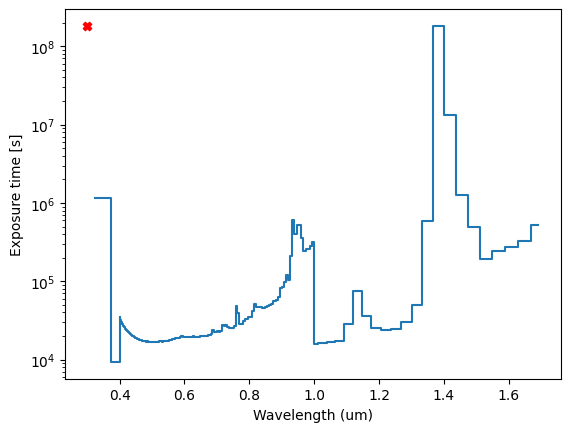

In [ ]:

plt.figure()
plt.step(observation.wavelength, observation.exptime, where="mid")
plt.scatter(observation.wavelength[np.isinf(observation.exptime)], np.max(observation.exptime[np.isfinite(observation.exptime)])*np.ones_like(observation.wavelength[np.isinf(observation.exptime)]), marker="X", color="red")

plt.ylabel("Exposure time [s]")
plt.xlabel("Wavelength (um)")

plt.yscale("log")


A more useful functionality for the observer is to calculate the SNR you get for each spectral bin when you give it an exposure time. To do this, we need to specify a different parameter called `obstime`. This is the exposure time at a reference lambda that will drive the observation. We can take one of the exposure times calculated above.

In [ ]:
# Given this reference lambda, define the target obstime
ref_lam = 0.5*u.um
ind_reflam = np.argmin(np.abs(observation.wavelength - ref_lam))
observation.obstime = observation.exptime[ind_reflam]

# Calculate the SNR for all bins
pE.calculate_exposure_time_or_snr(observation, scene, observatory, mode="signal_to_noise", verbose=False)


Let's plot it:

Text(0.5, 0, 'Wavelength (um)')

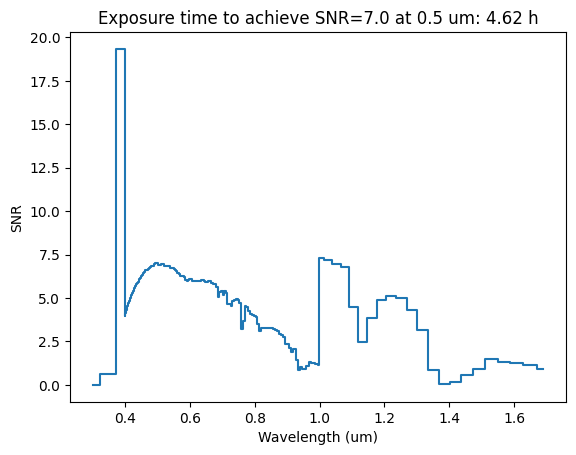

In [24]:
plt.figure()
plt.step(observation.wavelength, observation.fullsnr, where="mid")
plt.title(f"Exposure time to achieve SNR={parameters['snr'][0]} at {ref_lam}: {observation.obstime.to(u.hr).round(2)}")

plt.ylabel("SNR")
plt.xlabel("Wavelength (um)")

Now let's say you want to calculate different exposure times for the different spectral channels you may have specified at the beginning of this tutorial. This is how to do it with the ETC:

Text(0, 0.5, 'SNR')

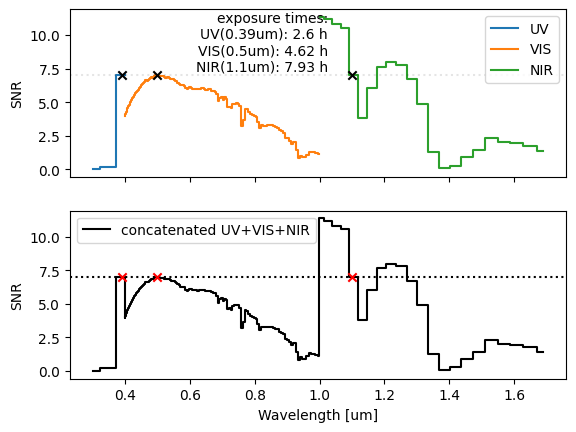

In [25]:
nchannels = len(parameters["spectral_resolution"])
# pick some reference lambdas: one for each channel. 
ref_lams = [0.39, 0.5, 1.1]

# ensure that there is one reference lambda per spectral channel
assert ref_lams[0] < parameters["lam_high"][0]
assert (ref_lams[1] >= parameters["lam_high"][0]) & (ref_lams[1] < parameters["lam_high"][1])
assert ref_lams[2] >= parameters["lam_high"][1]

# get the indeces corresponding to the spectral channels:
# remember, we are using observation.wavelength instead of parameters["wavelength"] because it is the re-gridded wavelength grid the ETC uses internally (we specified this earlier)
inds_UV = observation.wavelength.value < parameters["lam_high"][0]
inds_VIS = (observation.wavelength.value >= parameters["lam_high"][0]) & (observation.wavelength.value < parameters["lam_high"][1])
inds_NIR =  observation.wavelength.value >= parameters["lam_high"][1]

inds_arr = [inds_UV, inds_VIS, inds_NIR]

# to do this in a hacky way, we need to run the ETC three times: one for each spectral channel
snr_arrs = []
exptime_arr = []
for ref_lam in ref_lams:
    ind_reflam = np.argmin(np.abs(observation.wavelength - ref_lam*u.um))
    observation.obstime = observation.exptime[ind_reflam] # get the exposure time to given the results above 
    pE.calculate_exposure_time_or_snr(observation, scene, observatory, mode="signal_to_noise", verbose=False)
    snr_arrs.append(np.copy(observation.fullsnr))
    exptime_arr.append(np.copy(observation.exptime[ind_reflam]))

labels=["UV", "VIS", "NIR"]
fig, axes = plt.subplots(2,1, sharex=True)
snr_concat_arr = np.empty(len(observation.wavelength))

for i in range(len(ref_lams)):
    snr_arr = snr_arrs[i]
    inds = inds_arr[i]
    axes[0].step(observation.wavelength[inds], snr_arr[inds], label=labels[i], where="mid")
    #axes[0].scatter(observation.wavelength[inds][np.isinf(observation.exptime[inds])], np.max(snr_arr[inds][np.isfinite(observation.exptime[inds])])*np.ones_like(observation.wavelength[inds][np.isinf(observation.exptime[inds])]), marker="X", color="red")
    snr_concat_arr[inds] = snr_arr[inds]
axes[0].scatter(ref_lams, [7,7,7], color="k", marker="x", zorder=10)
axes[0].axhline(7, color="k", ls=":", alpha=0.1)
axes[0].legend()
axes[0].set_ylabel("SNR")
exptime_text = f"UV({ref_lams[0]}um): {exptime_arr[0].to(u.hr).round(2)}\nVIS({ref_lams[1]}um): {exptime_arr[1].to(u.hr).round(2)}\nNIR({ref_lams[2]}um): {exptime_arr[2].to(u.hr).round(2)}"
axes[0].text(0.52, 0.99, f"exposure times:\n{exptime_text}",  transform=axes[0].transAxes, ha='right', va='top')
axes[1].step(observation.wavelength, snr_concat_arr, color="k", label="concatenated UV+VIS+NIR", where="mid")
axes[1].scatter(ref_lams, [7,7,7], color="red", marker="x", zorder=10)
axes[1].axhline(7, color="k", ls=":")
axes[1].set_xlabel("Wavelength [um]")
axes[1].legend()
axes[1].set_ylabel("SNR")

## 2. Visualization

Every variable is stored in either of the defined classes (see [Glossary](glossary.md)). This means that we can easily plot any variable we need.

Throughput:

Text(0.5, 1.0, 'Total Throughput')

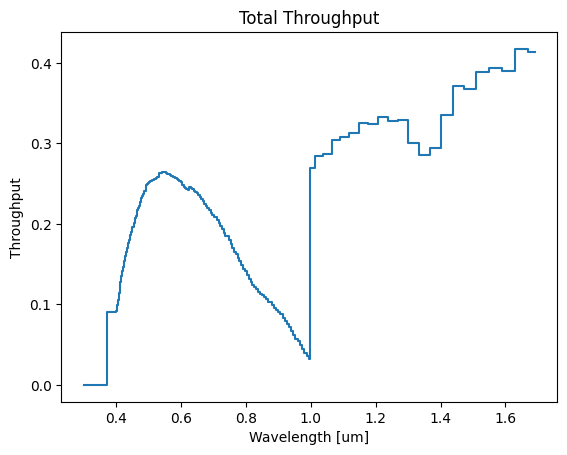

In [26]:
plt.figure()
plt.step(observation.wavelength, observatory.total_throughput, where="mid")
plt.xlabel("Wavelength [um]")
plt.ylabel("Throughput")
plt.title("Total Throughput")

Coronagraph response maps:

Text(0.5, 1.0, 'Coronagraph skytrans')

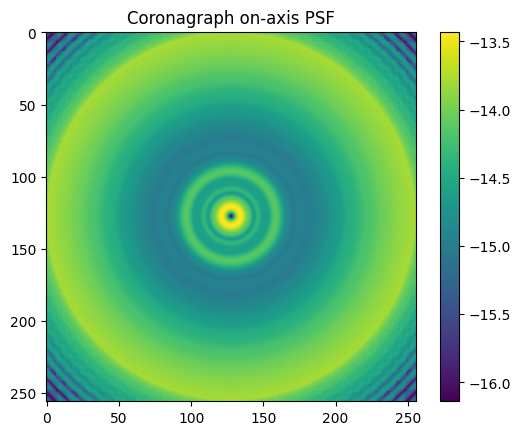

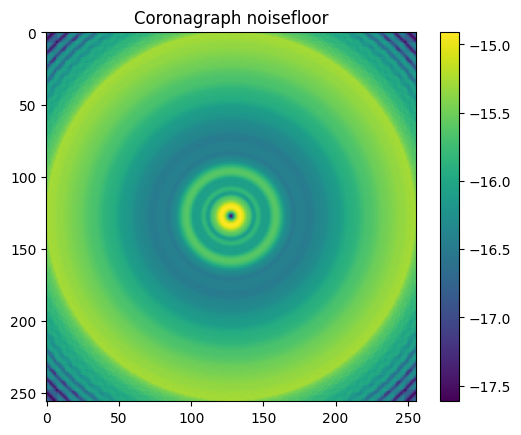

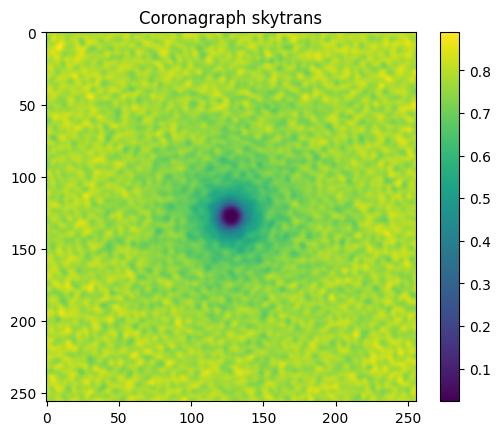

In [27]:
plt.figure()
plt.imshow(np.log10(observatory.coronagraph.Istar))
plt.colorbar()
plt.title("Coronagraph on-axis PSF")

plt.figure()
plt.imshow(np.log10(observatory.coronagraph.noisefloor))
plt.colorbar()
plt.title("Coronagraph noisefloor")

plt.figure()
plt.imshow(observatory.coronagraph.skytrans)
plt.colorbar()
plt.title("Coronagraph skytrans")



`pyEDITH` also has a specific function to synthesise observations:


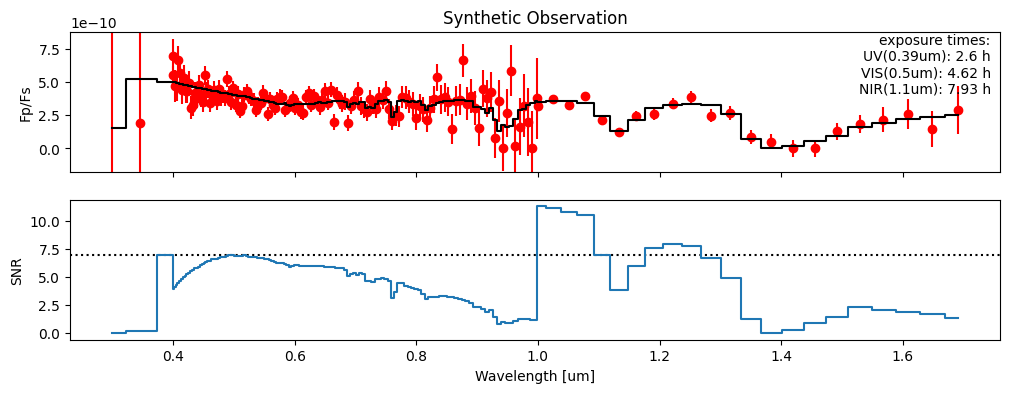

In [28]:
obs, noise = pE.utils.synthesize_observation(snr_concat_arr,
                                             exptime_arr,
                                             ref_lams,
                                             observation,
                                             scene, 
                                             random_seed=42, # seed defaults to None
                                             set_below_zero=0., # if the fake data falls below zero, set the data point as this. default = NaN
                                             )

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
axes[0].step(observation.wavelength, scene.Fp_over_Fs, color="k", where="mid", zorder=10)
axes[0].errorbar(observation.wavelength, obs, yerr=noise, fmt="o", color="red")
axes[0].set_ylabel("Fp/Fs")

axes[0].set_title("Synthetic Observation")
exptime_text = f"UV({ref_lams[0]}um): {exptime_arr[0].to(u.hr).round(2)}\nVIS({ref_lams[1]}um): {exptime_arr[1].to(u.hr).round(2)}\nNIR({ref_lams[2]}um): {exptime_arr[2].to(u.hr).round(2)}"
axes[0].text(0.99, 0.99, f"exposure times:\n{exptime_text}", transform=axes[0].transAxes, ha="right", va="top")
axes[0].set_ylim(np.median(scene.Fp_over_Fs) - 1.5 * np.median(scene.Fp_over_Fs), np.median(scene.Fp_over_Fs) + 1.5 * np.median(scene.Fp_over_Fs))
axes[1].step(observation.wavelength, snr_concat_arr, where="mid", zorder=10)
axes[1].set_xlabel("Wavelength [um]")
axes[1].set_ylabel("SNR")
axes[1].axhline(7, color="k", ls=":")


Photon counts can also be plotted (we use a logfile that is automatically created when running, `photon_counts.pk`):

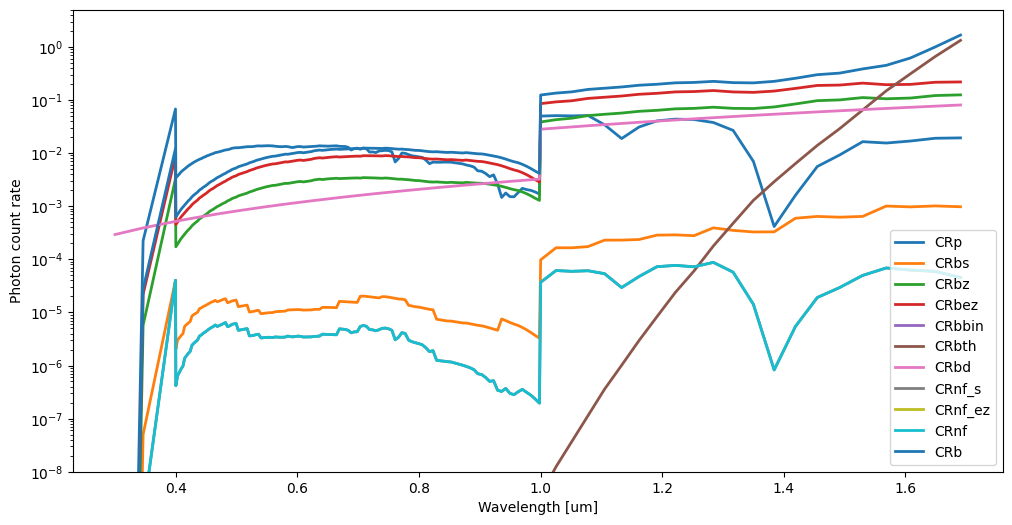

In [36]:
photon_counts = pickle.load(open("./photon_counts.pk", "rb"))
plt.figure(figsize=(12,6))
for key in photon_counts.keys():

    if key not in ["PPF_ez",'omega_lod']:
        plt.plot(observation.wavelength, photon_counts[key], label=key, lw=2)
plt.yscale("log")
plt.ylim(1e-8, 5e0)
plt.ylabel("Photon count rate")
plt.xlabel("Wavelength [um]")
plt.legend()